# V2 - Conv3D


In [ ]:
import os
import cv2
import numpy as np
import datetime as dt
import shutil
import pandas as pd
import random
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
%matplotlib inline

from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directory where clips are stored for training
path = '/content/drive/MyDrive/help-cam-assets_shared'
data_directory = f'{path}/downloads/selected_features'

# Separate test video
input_video_file_path = './test/Ring_Cindy_20240720_1917.mp4'
output_video_file_path = './predictions/prediction3.mp4'

# Training

## Functions

In [ ]:
def move_model(file_name):
  # Make timestamp
  date_time_format = '%Y_%m_%d__%H_%M_%S'
  current_date_time_dt = dt.datetime.now()
  current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

  default_path = f'./{file_name}'
  new_model_name = f'Model_3D___Date_Time_{current_date_time_string}_{file_name}'
  moved_path = f"{path}/Code and models/Trained models/{new_model_name}"

  print("Moving saved model")
  shutil.move(default_path, moved_path)

  print("Done")

In [ ]:
# 1. Load and Preprocess Videos
def load_videos_from_folders(folder_path, img_size=(64, 64), sequence_length=30):
    classes = os.listdir(folder_path)
    data, labels = [], []

    for label, activity in enumerate(classes):
        activity_folder = os.path.join(folder_path, activity)
        for video_file in os.listdir(activity_folder):
            video_path = os.path.join(activity_folder, video_file)
            frames = video_to_frames(video_path, img_size, sequence_length)
            if frames is not None:
                data.append(frames)
                labels.append(label)

    data = np.array(data)
    labels = to_categorical(labels, num_classes=len(classes))

    return data, labels, classes


def video_to_frames(video_path, img_size, sequence_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
        if len(frames) == sequence_length:
            break
    cap.release()

    if len(frames) < sequence_length:
        return None  # Ignore short videos

    return np.array(frames)


# 2. Build the Model
def build_3dcnn(input_shape, num_classes, conv_filters=[64, 128, 256], kernel_size=(3, 3, 3),
                dense_units=1024, dropout_rate=0.5, learning_rate=0.001):

    model = Sequential()

    # First Conv Layer
    model.add(Conv3D(conv_filters[0], kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second Conv Layer
    model.add(Conv3D(conv_filters[1], kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third Conv Layer
    model.add(Conv3D(conv_filters[2], kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# 3. Run multiple iterations of training and testing, and save models
def run_multiple_iterations(train_data_folder, iterations=5, epochs_list=[10, 20]):
    # Load data
    data, labels, activity_classes = load_videos_from_folders(train_data_folder)
    input_shape = (30, 64, 64, 3)  # (sequence_length, img_size, img_size, channels)
    num_classes = len(activity_classes)

    # To store results
    all_accuracies = []
    best_accuracy = 0.0
    best_model_path = None

    # Run for multiple iterations
    for i in range(iterations):
        print(f"\nIteration {i + 1}/{iterations}")

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=i)

        # Build and train the model
        model = build_3dcnn(input_shape, num_classes)

        # Train model for varying epochs
        for epochs in epochs_list:
            print(f"\nTraining with {epochs} epochs...")
            # model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=8, verbose=1)
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=8, verbose=1)  # added after 1st run
              # Add stratification

            # Evaluate model on validation set
            val_predictions = model.predict(X_val)
            val_predicted_labels = np.argmax(val_predictions, axis=1)
            val_true_labels = np.argmax(y_val, axis=1)

            # Calculate accuracy
            accuracy = accuracy_score(val_true_labels, val_predicted_labels)
            print(f"Validation Accuracy: {accuracy}")
            all_accuracies.append(accuracy)

            # Save the model if it's the best one so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_path = f"best_model_iter_{i+1}_epochs_{epochs}.h5"
                model.save(best_model_path)
                print(f"Model saved as {best_model_path} with accuracy {best_accuracy}")

    # Calculate average accuracy over all iterations
    avg_accuracy = np.mean(all_accuracies)
    print(f"\nAverage validation accuracy over {iterations} iterations: {avg_accuracy}")

    return avg_accuracy, best_model_path

In [ ]:
# Define random search function
def run_random_search(train_data_folder, param_grid, iterations=3, n_combinations=10):
    # Load data
    data, labels, activity_classes = load_videos_from_folders(train_data_folder)
    input_shape = (30, 64, 64, 3)  # (sequence_length, img_size, img_size, channels)
    num_classes = len(activity_classes)

    # To store results
    best_accuracy = 0.0
    best_params = None
    best_model_path = None
    best_val_true_labels = None
    best_val_predicted_labels = None

    # Randomly sample a subset of parameter combinations
    param_combinations = [dict(zip(param_grid.keys(), values)) for values in random.sample(list(product(*param_grid.values())), n_combinations)]

    for param_comb in param_combinations:
        # Unpack the current parameter combination
        params = dict(param_comb)
        print(f"\nTesting with parameters: {params}")

        for i in range(iterations):
            print(f"\nIteration {i + 1}/{iterations}")
            # Split data
            X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=i)

            # Build and train the model with the current hyperparameters
            model = build_3dcnn(
                input_shape, num_classes,
                conv_filters=params['conv_filters'],
                kernel_size=params['kernel_size'],
                dense_units=params['dense_units'],
                dropout_rate=params['dropout_rate'],
                learning_rate=params['learning_rate']
            )

            # Train the model for a set number of epochs
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)

            # Evaluate model on validation set
            val_predictions = model.predict(X_val)
            val_predicted_labels = np.argmax(val_predictions, axis=1)
            val_true_labels = np.argmax(y_val, axis=1)

            # Calculate accuracy for this iteration
            accuracy = accuracy_score(val_true_labels, val_predicted_labels)
            print(f"Iteration {i + 1} Validation Accuracy: {accuracy}")

            # Check if this is the best accuracy so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params
                best_model_path = f"best_model_{params}_accuracy_{best_accuracy:.2f}.h5"
                model.save(best_model_path)
                print(f"Best model saved with accuracy {best_accuracy}")

                # Store the best validation predictions and labels for confusion matrix
                best_val_true_labels = val_true_labels
                best_val_predicted_labels = val_predicted_labels

    # Print and plot confusion matrix for the best model
    if best_val_true_labels is not None and best_val_predicted_labels is not None:
        cm = confusion_matrix(best_val_true_labels, best_val_predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Best Model\nAccuracy: {best_accuracy:.2f}')
        plt.show()

    # Return the best parameters and accuracy
    print(f"\nBest hyperparameters: {best_params} with accuracy: {best_accuracy}")
    return best_params, best_accuracy, best_model_path


# Define grid search function
def run_grid_search(train_data_folder, param_grid, iterations=3):
    # Load data
    data, labels, activity_classes = load_videos_from_folders(train_data_folder)
    input_shape = (30, 64, 64, 3)  # (sequence_length, img_size, img_size, channels)
    num_classes = len(activity_classes)

    # To store results
    best_accuracy = 0.0
    best_params = None
    best_model_path = None
    best_val_true_labels = None
    best_val_predicted_labels = None

    # Generate all combinations of hyperparameters
    param_combinations = list(product(*param_grid.values()))

    for param_comb in param_combinations:
        # Unpack the current parameter combination
        params = dict(zip(param_grid.keys(), param_comb))
        print(f"\nTesting with parameters: {params}")

        for i in range(iterations):
            print(f"\nIteration {i + 1}/{iterations}")
            # Split data
            X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=i)

            # Build and train the model with the current hyperparameters
            model = build_3dcnn(
                input_shape, num_classes,
                conv_filters=params['conv_filters'],
                kernel_size=params['kernel_size'],
                dense_units=params['dense_units'],
                dropout_rate=params['dropout_rate'],
                learning_rate=params['learning_rate']
            )

            # Train the model for a set number of epochs
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)

            # Evaluate model on validation set
            val_predictions = model.predict(X_val)
            val_predicted_labels = np.argmax(val_predictions, axis=1)
            val_true_labels = np.argmax(y_val, axis=1)

            # Calculate accuracy for this iteration
            accuracy = accuracy_score(val_true_labels, val_predicted_labels)
            print(f"Iteration {i + 1} Validation Accuracy: {accuracy}")

            # Check if this is the best accuracy so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params
                best_model_path = f"best_model_{params}_accuracy_{best_accuracy:.2f}.h5"
                model.save(best_model_path)
                print(f"Best model saved with accuracy {best_accuracy}")

                # Store the best validation predictions and labels for confusion matrix
                best_val_true_labels = val_true_labels
                best_val_predicted_labels = val_predicted_labels

    # Print and plot confusion matrix for the best model
    if best_val_true_labels is not None and best_val_predicted_labels is not None:
        cm = confusion_matrix(best_val_true_labels, best_val_predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Best Model\nAccuracy: {best_accuracy:.2f}')
        plt.show()

    # Return the best parameters and accuracy
    print(f"\nBest hyperparameters: {best_params} with accuracy: {best_accuracy}")
    return best_params, best_accuracy, best_model_path

## A. Train model without grid search

In [ ]:
# # Example usage:
# train_data_folder = data_directory  # path to training data

# # Run 3 iterations with different train-test splits, train for 7 and 10 epochs
# average_accuracy, best_model_path = run_multiple_iterations(train_data_folder, iterations=3, epochs_list=[7, 10])

# # Move model to persistent storage
# move_model(best_model_path)

# print("Done")

## B: Train with grid search

In [1]:
param_grid = {
    'conv_filters': [[32, 64, 128], [64, 128, 256]],  # Filter sizes for the 3 Conv layers
    'kernel_size': [(3, 3, 3), (5, 5, 5)],  # Kernel size for Conv layers
    'dense_units': [512, 1024],  # Number of units in Dense layer
    'dropout_rate': [0.4, 0.5],  # Dropout rates
    'learning_rate': [0.001, 0.0001],  # Learning rates
    'batch_size': [8, 16],  # Batch size
    'epochs': [10, 20]  # Number of epochs
}

train_data_folder = data_directory  # path to training data

# Run grid search over multiple hyperparameters
best_params, best_accuracy, best_model_path = run_grid_search(train_data_folder, param_grid)

# Move model to persistent storage
move_model(best_model_path)

print("Done")

NameError: name 'data_directory' is not defined

# Load model

In [ ]:
# 3. Load the pre-trained model and activity classes
model_path = f"{path}/Code and models/Trained models//Model_3D___Date_Time_2024_09_13__13_55_01_best_model_iter_1_epochs_10.h5"  # Path to your saved model
model = load_model(model_path)

# Plot performance metrics

In [ ]:
# Uploaded from CSV -- note: model changed so metrics are stored moving forward
seven_epochs = './Conv3D_training_metrics - 7epochs.csv'
ten_epochs = './Conv3D_training_metrics - 10epochs.csv'

seven_df = pd.read_csv(seven_epochs)
ten_df = pd.read_csv(ten_epochs)

seven1 = seven_df.loc[seven_df['iteration'] == 1]
seven2 = seven_df.loc[seven_df['iteration'] == 2]
seven3 = seven_df.loc[seven_df['iteration'] == 3]

ten_1 = ten_df.loc[ten_df['iteration'] == 1]
ten_2 = ten_df.loc[ten_df['iteration'] == 2]
ten_3 = ten_df.loc[ten_df['iteration'] == 3]

seven_e = [seven1, seven2, seven3]
ten_e = [ten_1, ten_2, ten_3]

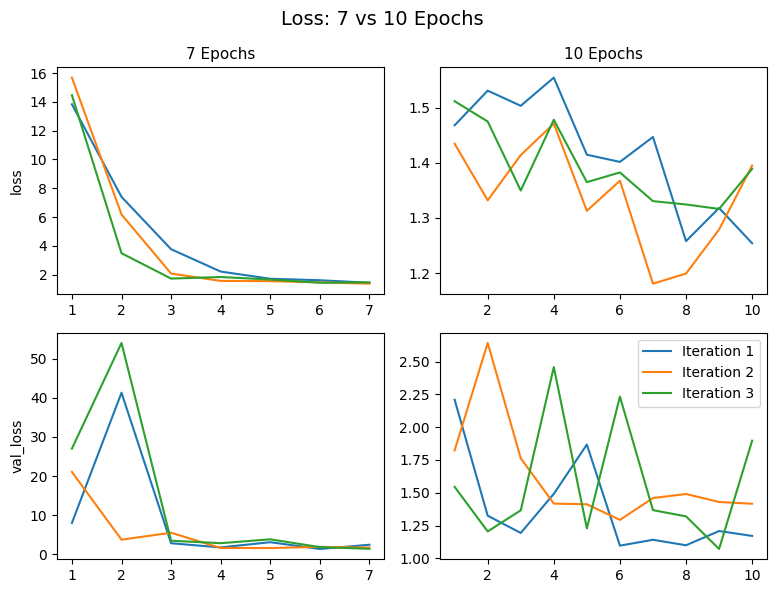

In [ ]:
# Plot loss
idx = 1

fig, axs = plt.subplots(2, 2, figsize=(8, 6), layout='tight')

for s in seven_e:
  axs[0, 0].plot(s['epoch'], s['loss'], label = f"Iteration {idx}")
  axs[1, 0].plot(s['epoch'], s['val_loss'], label = f"Iteration {idx}")
  idx += 1

idx = 1

for t in ten_e:
  axs[0, 1].plot(t['epoch'], t['loss'], label = f"Iteration {idx}")
  axs[1, 1].plot(t['epoch'], t['val_loss'], label = f"Iteration {idx}")
  idx += 1

# Set titles
plt.suptitle("Loss: 7 vs 10 Epochs", fontsize=14)
axs[0, 0].set_title("7 Epochs", fontsize=11)
axs[0, 1].set_title("10 Epochs", fontsize=11)

# Set labels
axs[0, 0].set_ylabel('loss')
axs[1, 0].set_ylabel('val_loss')

plt.legend()

plt.show()

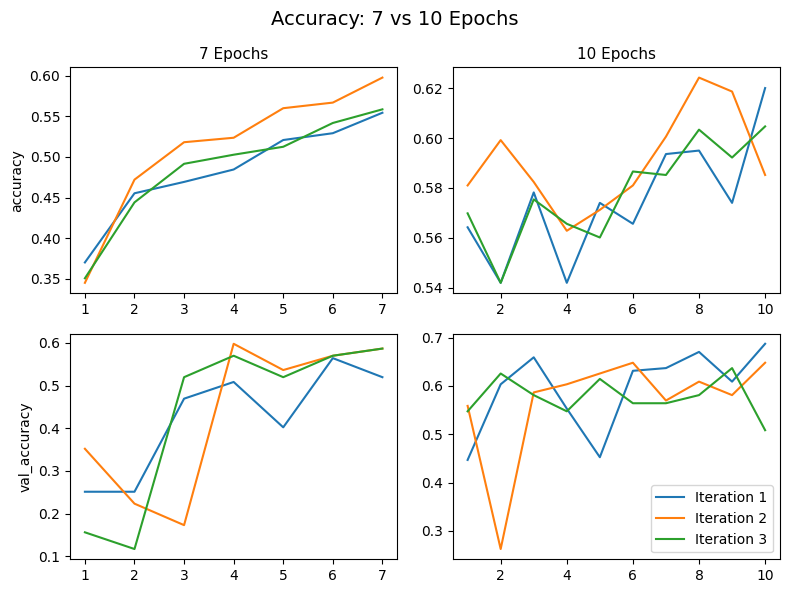

In [ ]:
# Plot accuracy
idx = 1

fig, axs = plt.subplots(2, 2, figsize=(8, 6), layout='tight')

for s in seven_e:
  axs[0, 0].plot(s['epoch'], s['accuracy'], label = f"Iteration {idx}")
  axs[1, 0].plot(s['epoch'], s['val_accuracy'], label = f"Iteration {idx}")
  idx += 1

idx = 1

for t in ten_e:
  axs[0, 1].plot(t['epoch'], t['accuracy'], label = f"Iteration {idx}")
  axs[1, 1].plot(t['epoch'], t['val_accuracy'], label = f"Iteration {idx}")
  idx += 1

# Set titles
plt.suptitle("Accuracy: 7 vs 10 Epochs", fontsize=14)
axs[0, 0].set_title("7 Epochs", fontsize=11)
axs[0, 1].set_title("10 Epochs", fontsize=11)

# Set labels
axs[0, 0].set_ylabel('accuracy')
axs[1, 0].set_ylabel('val_accuracy')

plt.legend()

plt.show()

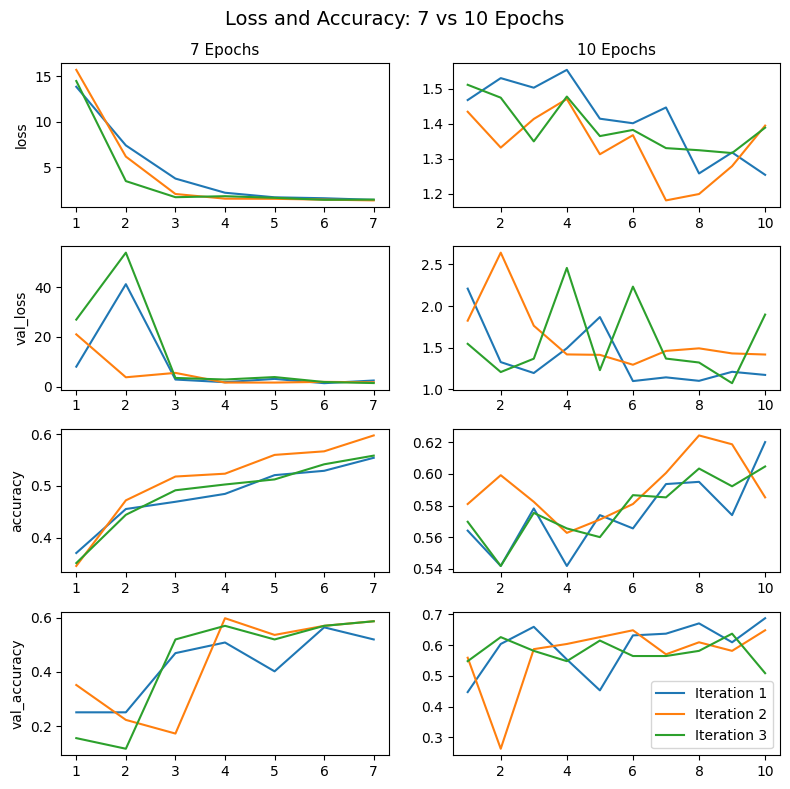

In [ ]:
# Plot results
idx = 1

fig, axs = plt.subplots(4, 2, figsize=(8, 8), layout='tight')

for s in seven_e:
  axs[0, 0].plot(s['epoch'], s['loss'], label = f"Iteration {idx}")
  axs[1, 0].plot(s['epoch'], s['val_loss'], label = f"Iteration {idx}")
  axs[2, 0].plot(s['epoch'], s['accuracy'], label = f"Iteration {idx}")
  axs[3, 0].plot(s['epoch'], s['val_accuracy'], label = f"Iteration {idx}")
  idx += 1

idx = 1

for t in ten_e:
  axs[0, 1].plot(t['epoch'], t['loss'], label = f"Iteration {idx}")
  axs[1, 1].plot(t['epoch'], t['val_loss'], label = f"Iteration {idx}")
  axs[2, 1].plot(t['epoch'], t['accuracy'], label = f"Iteration {idx}")
  axs[3, 1].plot(t['epoch'], t['val_accuracy'], label = f"Iteration {idx}")
  idx += 1

# Set titles
plt.suptitle("Loss and Accuracy: 7 vs 10 Epochs", fontsize=14)
axs[0, 0].set_title("7 Epochs", fontsize=11)
axs[0, 1].set_title("10 Epochs", fontsize=11)

# Set labels
axs[0, 0].set_ylabel('loss')
axs[1, 0].set_ylabel('val_loss')
axs[2, 0].set_ylabel('accuracy')
axs[3, 0].set_ylabel('val_accuracy')

plt.legend(loc='lower right')

plt.show()

# Inference on live video

In [ ]:
# 1. Define a function to process frames from the webcam
def process_live_frames(img_size=(64, 64), sequence_length=30):
    cap = cv2.VideoCapture(0)  # Open webcam (0 is the default for most cameras)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame to match the model input size
        resized_frame = cv2.resize(frame, img_size)
        frames.append(resized_frame)

        # Display the frame
        cv2.imshow('Live Video Feed', frame)

        # If we have enough frames for a sequence, yield them for prediction
        if len(frames) == sequence_length:
            yield np.array(frames)  # Return sequence as numpy array
            frames = []  # Reset for the next sequence

        # Press 'q' to exit the live feed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# 2. Function to predict activity on live frames
def predict_live_activity(model, activity_classes, img_size=(64, 64), sequence_length=30):
    for frames in process_live_frames(img_size, sequence_length):
        frames = np.expand_dims(frames, axis=0)  # Add batch dimension
        prediction = model.predict(frames)
        predicted_label = np.argmax(prediction, axis=1)[0]
        predicted_activity = activity_classes[predicted_label]

        print(f"Predicted Activity: {predicted_activity}")

In [ ]:
# Assuming `activity_classes` is the list of activities in your training data
activity_classes = ['Activity1', 'Activity2', 'Activity3']

# 4. Start the live prediction
process_live_frames(model, activity_classes, img_size=(64, 64), sequence_length=30)

In [ ]:
# 1. Define a function to process frames from the webcam
def process_live_frames(img_size=(64, 64), sequence_length=30):
    cap = cv2.VideoCapture(0)  # Open webcam (0 is the default for most cameras)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame to match the model input size
        resized_frame = cv2.resize(frame, img_size)
        frames.append(resized_frame)

        # Display the frame
        cv2.imshow('Live Video Feed', frame)

        # If we have enough frames for a sequence, yield them for prediction
        if len(frames) == sequence_length:
            yield np.array(frames)  # Return sequence as numpy array
            frames = []  # Reset for the next sequence

        # Press 'q' to exit the live feed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# 2. Function to predict activity on live frames
def predict_live_activity(model, activity_classes, img_size=(64, 64), sequence_length=30):
    for frames in process_live_frames(img_size, sequence_length):
        frames = np.expand_dims(frames, axis=0)  # Add batch dimension
        prediction = model.predict(frames)
        predicted_label = np.argmax(prediction, axis=1)[0]
        predicted_activity = activity_classes[predicted_label]

        print(f"Predicted Activity: {predicted_activity}")

In [ ]:
cap = True

while

< cv2.VideoCapture 0x7934ec37adf0>